## ETF Correlation Analysis

Analysing correlation for ETF between themselves, as well as part of the variance explained by componenets taken from PCA 

In [84]:
# Import Modules
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loading Data
with (open('data/etfs_sectors_10_20230427.pkl', "rb")) as openfile:
    data_etf = pickle.load(openfile)

# First Task
def first_task(db):
    """
    Calculate correlation of return (OPEN/CLOSE) between sectors ETFs, considering a 500 rows window

    Return
    ---
        db_summary : pd.DataFrame
            Table containing Q1, Q9 and Median for the historic period
        _ : plt
            Grid of plots, showing historical development for each unique ETF pair
    
    """
    etf_list = db["close"].columns[db["close"].columns.str.contains('X')]
    db = db["close"].div(db["open"])[etf_list].dropna()

    db = db.rolling(window=500).corr().dropna()

    db = db.reset_index(level=1)

    db = db.pivot(columns=['level_1'])

    stay_list = {*map(tuple, map(sorted, db.columns.values))}
    db.columns = ['_'.join(col) if (col[0] != col[1]) and (col in stay_list) else 'IGNORE' for col in db.columns.values]
    db.drop('IGNORE', inplace=True, axis=1)

    _ = db.plot(subplots=True, 
                layout=(8,7),
                figsize=(40,50), 
                sharex=True, 
                sharey=True)

    db_summary = pd.DataFrame([db.quantile(0.1).values, db.quantile(0.9).values, db.median().values], 
                                columns=db.columns, 
                                index=['Q1', 'Q9', 'Median']) 

    return db_summary

# Second Task
def second_task(db):
    """
    Calculate portion of variance explication due to 3 main components considering covariance of return (OPEN/CLOSE) between sectors ETFs, considering a 500 rows window

    Return
    ---
        db_summary : pd.DataFrame
            Historical data of % of explication for the 3 main components 
        _ : plt
            Development of % of explication for the 3 main components 
    
    """
    etf_list = data_etf["close"].columns[data_etf["close"].columns.str.contains('X')]
    db = data_etf["close"].div(data_etf["open"])[etf_list].dropna()

    db = db.rolling(window=500).cov().dropna()

    db.index = db.index.droplevel(1)
    db = db.groupby(db.index).apply(lambda x: pd.Series(np.linalg.eigvals(x)[:3]/sum(np.linalg.eigvals(x)), index=['COMP1', 'COMP2', 'COMP3']))

    db.plot()

    return db


### Playground with intraday data

Analysing Bid-Ask Spread assuming volume-weighted price

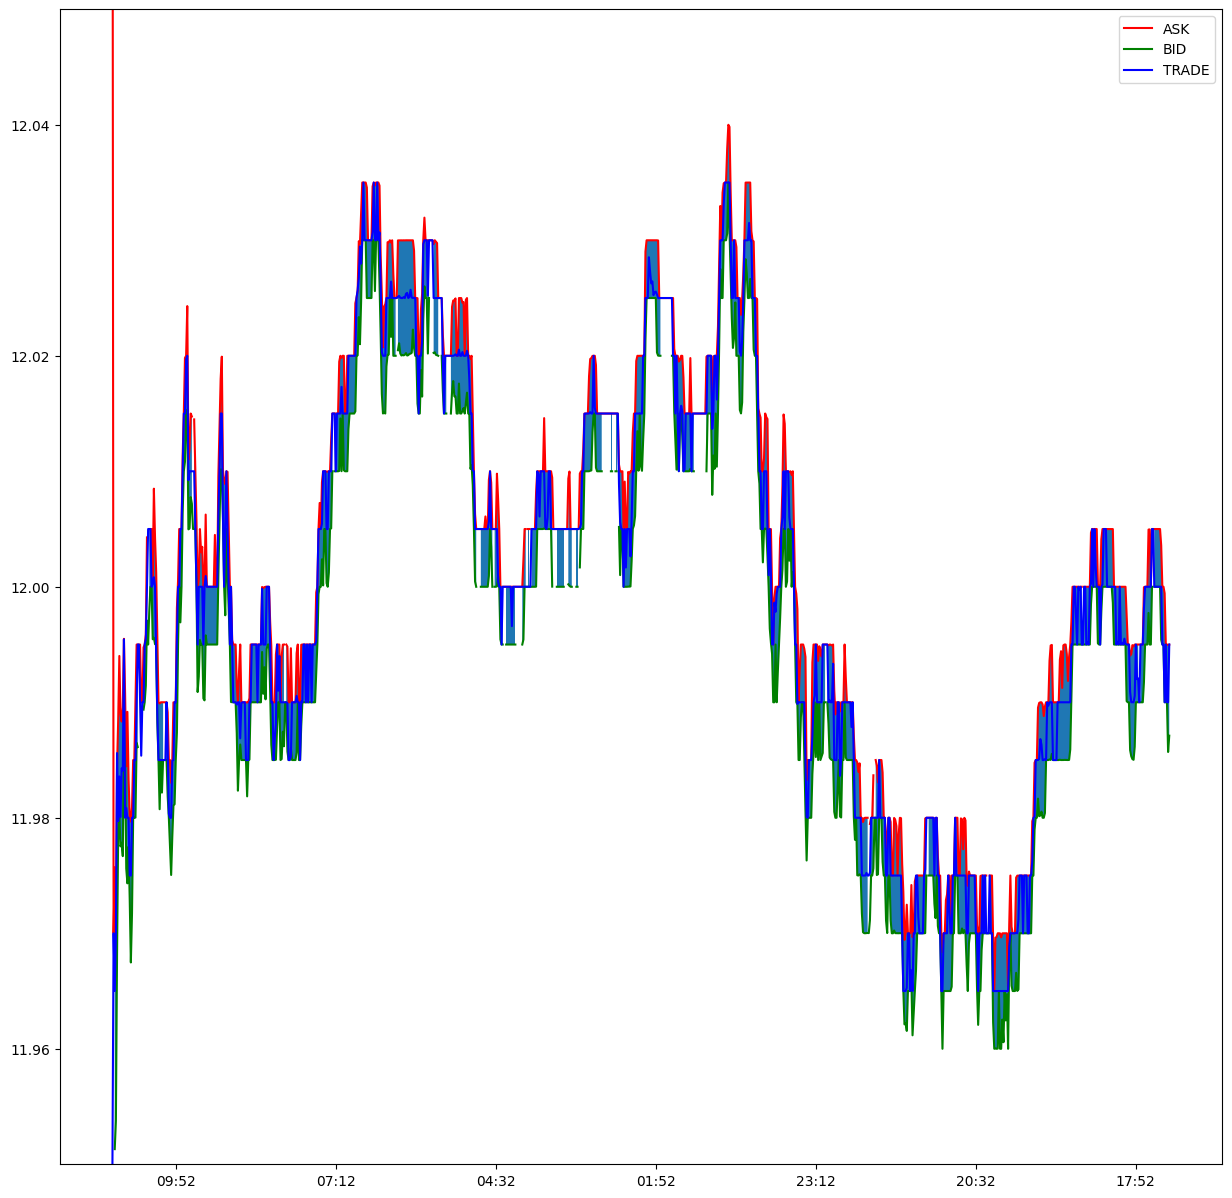

In [211]:
db = pd.read_csv('data/ODF25_Comdty_20230428.txt', sep='\t', header=None, index_col=False).dropna(axis=1)
db.columns = ['date', 'type', 'price', 'vol']
db.date = pd.to_datetime(db.date).dt.strftime('%H:%M:%S')

db.loc[db["type"] == "BID", ['date']] = None
db.loc[db["type"] == "ASK", ['date']] = None

db.loc[:,['date']] = db.loc[:,['date']].bfill()
db.set_index('date', inplace=True)
db = db.groupby(['date', 'type']).apply(lambda x: np.average(x['price'], weights=x['vol']))

intra_db = pd.DataFrame(db, columns=['volw_price']).reset_index(level=1).pivot(columns='type', values='volw_price')

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1) 

plt.plot(intra_db.index, intra_db.ASK, 'r-', label='ASK')
plt.plot(intra_db.index, intra_db.BID, 'g-', label='BID')
plt.plot(intra_db.index, intra_db.TRADE, 'b-', label='TRADE')
plt.fill_between(intra_db.index, intra_db.ASK, intra_db.BID)

plt.ylim((11.950, 12.050))
plt.legend()

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=200000))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

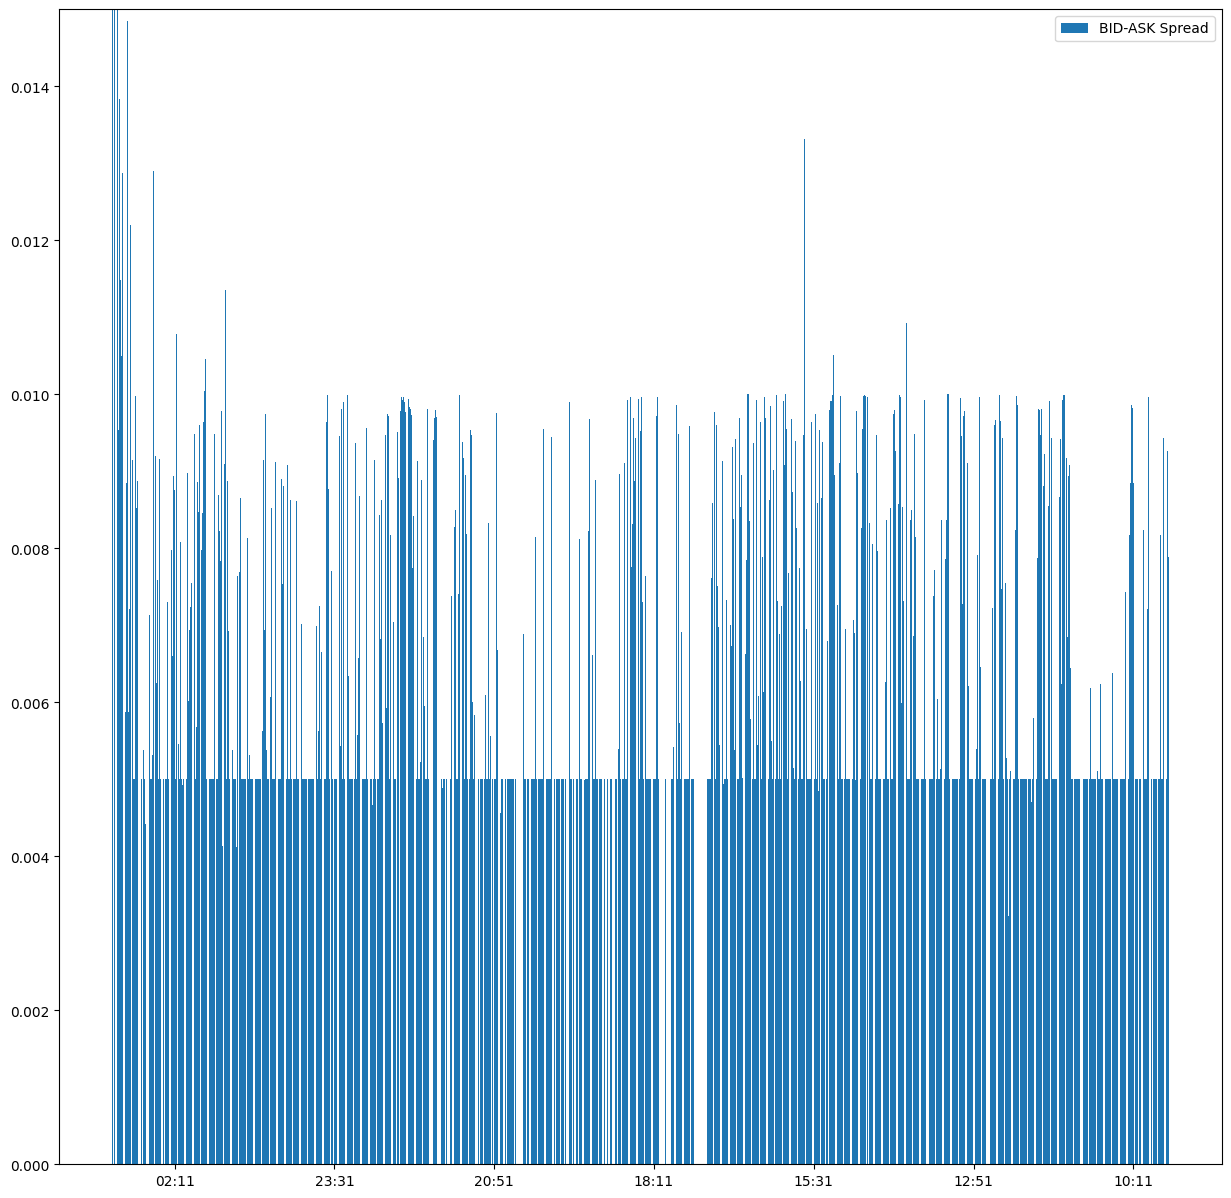

In [217]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1) 

plt.bar(intra_db.index, intra_db.ASK - intra_db.BID, label='BID-ASK Spread')

plt.ylim((0, 0.015))
plt.legend()

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=200000))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


#### Duvidas

- Só esclarescimento sobre os termos: UXT, LQDZ, O-OA etc. Aparecem quando tem-se um trade completado